The purpose of this notebook is to test for bifurcations in a version of the ice thickness distribution model using *Smoluchowski coagulation mechanics* instead of the Fokker-Planck mechanics parameterisation.

In [1]:
from ice_distribution_class import IceDistModel
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
from IPython import display

plt.rcParams.update({'font.size': 14})
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
#generate a set of ice model instances with different delta_F_0 values and ice-covered and ice-free initial conditions

%matplotlib inline

ice_covered_ics = {}
ice_free_ics = {}

ice_covered_ic_distribution_series = {}
ice_free_ic_distribution_series = {}
ice_covered_ic_mean_thickness_series = {}
ice_free_ic_mean_thickness_series = {}
ice_covered_ic_T_ml_series = {}
ice_free_ic_T_ml_series = {}
ice_covered_ic_E_series = {}
ice_free_ic_E_series = {}
ice_covered_ic_growth_rate_series = {}
ice_free_ic_growth_rate_series = {}

delta_F_0_values = np.array([
    0,5,10
])

#set parameters that will be the same across all models
thickness_interval = 1e-1
timestep = 2*3600
thickness_maximum = 10
ice_free_T_ml = 5
ridging_rate = 0
rifting_rate = 0
kernel = 'linear'
flux_data = 'ew09'

steady_state_threshold = 1e-8

ridging_rates = [
    1.e-7,
]

ridging_rate_data = {}

for ridging_rate in ridging_rates:
    
    print(f"""#########################
    Ridging rate = {ridging_rate}
    #########################""")
    
    ridging_rate_data[f'{ridging_rate}'] = {}
    
    for delta_F_0 in delta_F_0_values:
        
        if delta_F_0==delta_F_0_values.min():
            ice_covered_ics[f'{delta_F_0}'] = sea_ice = IceDistModel(
                thickness_interval=thickness_interval,
                timestep=timestep,
                thickness_maximum=thickness_maximum,
                delta_F_0=delta_F_0,
                T_ml=0, #set mixed layer temperature to zero
                #this by default initialises the model in an ice-covered state
                rifting_rate=rifting_rate,
                ridging_rate=ridging_rate,
                flux_data=flux_data,
                kernel=kernel
            )
        elif ice_covered_ic_T_ml_series[f'{previous_delta_F_0}'][0]<=0:
            ice_covered_ics[f'{delta_F_0}'] = sea_ice = IceDistModel(
                thickness_interval=thickness_interval,
                timestep=timestep,
                thickness_maximum=thickness_maximum,
                delta_F_0=delta_F_0,
                initial_distribution=ice_covered_ic_distribution_series[f'{previous_delta_F_0}'][0],
                T_ml=0, #set mixed layer temperature to zero
                #this by default initialises the model in an ice-covered state
                rifting_rate=rifting_rate,
                ridging_rate=ridging_rate,
                flux_data=flux_data,
                kernel=kernel
            )
        else:
            ice_covered_ics[f'{delta_F_0}'] = sea_ice = IceDistModel(
                thickness_interval=thickness_interval,
                timestep=timestep,
                thickness_maximum=thickness_maximum,
                delta_F_0=delta_F_0,
                initial_distribution=None,
                T_ml=ice_covered_ic_T_ml_series[f'{previous_delta_F_0}'][0], #set mixed layer temperature to zero
                #this by default initialises the model in an ice-covered state
                rifting_rate=rifting_rate,
                ridging_rate=ridging_rate,
                flux_data=flux_data,
                kernel=kernel
            )
        ice_covered_ic_distribution_series[f'{delta_F_0}'] = np.zeros(
            (
                ice_covered_ics[f'{delta_F_0}']._timesteps_in_year,
                ice_covered_ics[f'{delta_F_0}']._thickness_coordinates.size
            )
        )
        ice_covered_ic_mean_thickness_series[f'{delta_F_0}'] = np.zeros(ice_covered_ics[f'{delta_F_0}']._timesteps_in_year)
        ice_covered_ic_T_ml_series[f'{delta_F_0}'] = np.zeros(ice_covered_ics[f'{delta_F_0}']._timesteps_in_year)
        ice_covered_ic_E_series[f'{delta_F_0}'] = np.zeros(ice_covered_ics[f'{delta_F_0}']._timesteps_in_year)
        ice_covered_ic_growth_rate_series[f'{delta_F_0}'] = np.zeros(
            (
                ice_covered_ics[f'{delta_F_0}']._timesteps_in_year,
                ice_covered_ics[f'{delta_F_0}']._thickness_coordinates.size
            )
        )
        
        print(f"""~~~~~~~~~~~~~
    delta_F_0 = {delta_F_0}
    ~~~~~~~~~~~~~""")
        
        #begin steady state evolution for ice covered ics
        t=0
        reached_steady_state = False
        previous_year_E_series = np.zeros(ice_covered_ics[f'{delta_F_0}']._timesteps_in_year)
        print('ICE COVERED IC')
        while reached_steady_state == False:
            t+=1
            ice_covered_ics[f'{delta_F_0}'].interpolate_forcing()
            ice_covered_ics[f'{delta_F_0}'].calculate_temperature()
            ice_covered_ics[f'{delta_F_0}'].calculate_growth_rate()
            ice_covered_ics[f'{delta_F_0}'].grow_ice()
            ice_covered_ics[f'{delta_F_0}'].export_ice()
            ice_covered_ics[f'{delta_F_0}'].do_coagulation_fragmentation_mechanics()

            ice_covered_ics[f'{delta_F_0}'].advance_time()
            
            #update current year time series
            ice_covered_ic_distribution_series[f'{delta_F_0}'][t%sea_ice._timesteps_in_year] = ice_covered_ics[f'{delta_F_0}']._thickness_distribution
            ice_covered_ic_growth_rate_series[f'{delta_F_0}'][t%sea_ice._timesteps_in_year] = ice_covered_ics[f'{delta_F_0}']._growth_rate
            ice_covered_ic_mean_thickness_series[f'{delta_F_0}'][t%sea_ice._timesteps_in_year] = ice_covered_ics[f'{delta_F_0}'].calculate_mean_thickness()[0]
            ice_covered_ic_T_ml_series[f'{delta_F_0}'][t%sea_ice._timesteps_in_year] = ice_covered_ics[f'{delta_F_0}']._T_ml
            if ice_covered_ics[f'{delta_F_0}']._T_ml<=0:
                ice_covered_ic_E_series[f'{delta_F_0}'][t%sea_ice._timesteps_in_year] = -ice_covered_ic_mean_thickness_series[f'{delta_F_0}'][t%sea_ice._timesteps_in_year]*ice_covered_ics[f'{delta_F_0}']._rho_i*ice_covered_ics[f'{delta_F_0}']._L_i
            else:
                ice_covered_ic_E_series[f'{delta_F_0}'][t%sea_ice._timesteps_in_year] = ice_covered_ics[f'{delta_F_0}']._T_ml*(ice_covered_ics[f'{delta_F_0}']._H_ml*ice_covered_ics[f'{delta_F_0}']._c_ml)
                
            if t%ice_covered_ics[f'{delta_F_0}']._timesteps_in_year==0:
                E_change_series = (ice_covered_ic_E_series[f'{delta_F_0}']-previous_year_E_series)/ice_covered_ic_E_series[f'{delta_F_0}'].ptp()
                E_mean_square_change = np.sum(E_change_series**2)/np.size(E_change_series)

                print(E_mean_square_change/steady_state_threshold)
                print('-----------------')
                if E_mean_square_change<steady_state_threshold:
                    print('reached_steady_state!')
                    print('********************')
                    #adjust bolean to say system has reached steady state, breaking the cycle
                    reached_steady_state=True
                else:
                    previous_year_E_series = np.copy(ice_covered_ic_E_series[f'{delta_F_0}'])
        #and now do the same for ice free ics
        if delta_F_0==delta_F_0_values.min() or ice_free_ic_T_ml_series[f'{previous_delta_F_0}'][0]<=0:
            ice_free_ics[f'{delta_F_0}'] = sea_ice = IceDistModel(
                thickness_interval=thickness_interval,
                timestep=timestep,
                thickness_maximum=thickness_maximum,
                delta_F_0=delta_F_0,
                T_ml=ice_free_T_ml, #set mixed layer temperature to positive value
                #this by default initialises the model in an ice-free state
                rifting_rate=rifting_rate,
                ridging_rate=ridging_rate,
                flux_data=flux_data,
                kernel=kernel
            )
        else:
            ice_free_ics[f'{delta_F_0}'] = sea_ice = IceDistModel(
                thickness_interval=thickness_interval,
                timestep=timestep,
                thickness_maximum=thickness_maximum,
                delta_F_0=delta_F_0,
                T_ml=ice_free_ic_T_ml_series[f'{previous_delta_F_0}'][0], #set mixed layer temperature to zero
                #this by default initialises the model in an ice-covered state
                rifting_rate=rifting_rate,
                ridging_rate=ridging_rate,
                flux_data=flux_data,
                kernel=kernel
            )
        ice_free_ic_distribution_series[f'{delta_F_0}'] = np.zeros(
            (
                ice_free_ics[f'{delta_F_0}']._timesteps_in_year,
                ice_free_ics[f'{delta_F_0}']._thickness_coordinates.size
            )
        )
        ice_free_ic_mean_thickness_series[f'{delta_F_0}'] = np.zeros(ice_free_ics[f'{delta_F_0}']._timesteps_in_year)
        ice_free_ic_T_ml_series[f'{delta_F_0}'] = np.zeros(ice_free_ics[f'{delta_F_0}']._timesteps_in_year)
        ice_free_ic_E_series[f'{delta_F_0}'] = np.zeros(ice_free_ics[f'{delta_F_0}']._timesteps_in_year)
        ice_free_ic_growth_rate_series[f'{delta_F_0}'] = np.zeros(
            (
                ice_free_ics[f'{delta_F_0}']._timesteps_in_year,
                ice_free_ics[f'{delta_F_0}']._thickness_coordinates.size
            )
        )
        t=0
        reached_steady_state = False
        previous_year_E_series = np.zeros(ice_free_ics[f'{delta_F_0}']._timesteps_in_year)
        print('ICE FREE IC')
        while reached_steady_state == False:
            t+=1
            ice_free_ics[f'{delta_F_0}'].interpolate_forcing()
            ice_free_ics[f'{delta_F_0}'].calculate_temperature()
            ice_free_ics[f'{delta_F_0}'].calculate_growth_rate()
            ice_free_ics[f'{delta_F_0}'].grow_ice()
            ice_free_ics[f'{delta_F_0}'].export_ice()
            ice_free_ics[f'{delta_F_0}'].do_coagulation_fragmentation_mechanics()

            ice_free_ics[f'{delta_F_0}'].advance_time()
            
            #update current year time series
            ice_free_ic_distribution_series[f'{delta_F_0}'][t%sea_ice._timesteps_in_year] = ice_free_ics[f'{delta_F_0}']._thickness_distribution
            ice_free_ic_growth_rate_series[f'{delta_F_0}'][t%sea_ice._timesteps_in_year] = ice_free_ics[f'{delta_F_0}']._growth_rate
            ice_free_ic_mean_thickness_series[f'{delta_F_0}'][t%sea_ice._timesteps_in_year] = ice_free_ics[f'{delta_F_0}'].calculate_mean_thickness()[0]
            ice_free_ic_T_ml_series[f'{delta_F_0}'][t%sea_ice._timesteps_in_year] = ice_free_ics[f'{delta_F_0}']._T_ml
            if ice_free_ics[f'{delta_F_0}']._T_ml<=0:
                ice_free_ic_E_series[f'{delta_F_0}'][t%sea_ice._timesteps_in_year] = -ice_free_ic_mean_thickness_series[f'{delta_F_0}'][t%sea_ice._timesteps_in_year]*ice_free_ics[f'{delta_F_0}']._rho_i*ice_free_ics[f'{delta_F_0}']._L_i
            else:
                ice_free_ic_E_series[f'{delta_F_0}'][t%sea_ice._timesteps_in_year] = ice_free_ics[f'{delta_F_0}']._T_ml*(ice_free_ics[f'{delta_F_0}']._H_ml*ice_free_ics[f'{delta_F_0}']._c_ml)
                
            if t%ice_free_ics[f'{delta_F_0}']._timesteps_in_year==0:
                E_change_series = (ice_free_ic_E_series[f'{delta_F_0}']-previous_year_E_series)/ice_free_ic_E_series[f'{delta_F_0}'].ptp()
                E_mean_square_change = np.sum(E_change_series**2)/np.size(E_change_series)

                print(E_mean_square_change/steady_state_threshold)
                print('-----------------')
                if E_mean_square_change<steady_state_threshold:
                    print('reached_steady_state!')
                    print('********************')
                    #adjust bolean to say system has reached steady state, breaking the cycle
                    reached_steady_state=True
                else:
                    previous_year_E_series = np.copy(ice_free_ic_E_series[f'{delta_F_0}'])
        
        previous_delta_F_0 = delta_F_0
    
    ridging_rate_data[f'{ridging_rate}']['delta_F_0_values'] = delta_F_0_values
    ridging_rate_data[f'{ridging_rate}']['thickness_coordinates'] = ice_free_ics[f'{delta_F_0}']._thickness_coordinates
    ridging_rate_data[f'{ridging_rate}']['flux_data'] = flux_data
    ridging_rate_data[f'{ridging_rate}']['coagulation_kernel'] = kernel
    ridging_rate_data[f'{ridging_rate}']['ice_covered_ic_distribution_series'] = ice_covered_ic_distribution_series
    ridging_rate_data[f'{ridging_rate}']['ice_covered_ic_mean_thickness_series'] = ice_covered_ic_mean_thickness_series
    ridging_rate_data[f'{ridging_rate}']['ice_covered_ic_T_ml_series'] = ice_covered_ic_T_ml_series
    ridging_rate_data[f'{ridging_rate}']['ice_free_ic_distribution_series'] = ice_free_ic_distribution_series
    ridging_rate_data[f'{ridging_rate}']['ice_free_ic_mean_thickness_series'] = ice_free_ic_mean_thickness_series
    ridging_rate_data[f'{ridging_rate}']['ice_free_ic_T_ml_series'] = ice_free_ic_T_ml_series

#########################
    Ridging rate = 1e-07
    #########################
~~~~~~~~~~~~~
    delta_F_0 = 0
    ~~~~~~~~~~~~~
ICE COVERED IC
108991783.66874294
-----------------
983445.5819837251
-----------------
40944.726464170366
-----------------
203.27981591960682
-----------------
0.2113692299589826
-----------------
reached_steady_state!
********************
ICE FREE IC


C:\Users\derby\Ice_only_models\sample code\ice_distribution_class.py:241: RuntimeWarning: invalid value encountered in double_scalars
  ice_mean_thickness = integrate.trapz(self._thickness_distribution*self._thickness_coordinates,self._thickness_coordinates)/integrate.trapz(self._thickness_distribution,self._thickness_coordinates) #mean thickness within the ice covered region


39916826.7847576
-----------------
89057011.34953022
-----------------
52822044.631235085
-----------------
5322471.910691745
-----------------
161327.0079149894
-----------------
379.0739233503545
-----------------
4.50107701874423
-----------------
0.1593395262558425
-----------------
reached_steady_state!
********************
~~~~~~~~~~~~~
    delta_F_0 = 5
    ~~~~~~~~~~~~~
ICE COVERED IC
70866149.73173153
-----------------
202798.763258133
-----------------
3630.3444636068475
-----------------
29.59890230982968
-----------------
0.1325515061987287
-----------------
reached_steady_state!
********************
ICE FREE IC
45454769.07454442
-----------------
37112377.96067657
-----------------
47110125.93774136
-----------------
10841298.966562446
-----------------
1368591.0863120942
-----------------
66826.07988387892
-----------------
892.9173091182569
-----------------
5.671367225866068
-----------------
0.016896267220121167
-----------------
reached_steady_state!
*****************

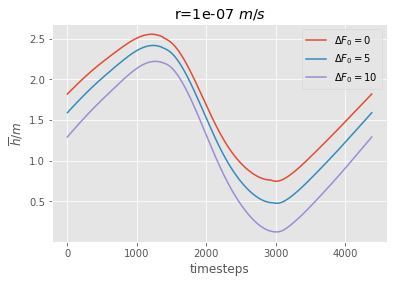

In [3]:
for key in ridging_rate_data.keys():
    fig,ax = plt.subplots(len(ridging_rate_data))
    for delta_F_0 in ridging_rate_data[key]['delta_F_0_values']:
        ax.plot(
            ridging_rate_data[key]['ice_covered_ic_mean_thickness_series'][f'{delta_F_0}'],
            label=f'$\Delta F_0=${delta_F_0}'
        )
        ax.legend()
        ax.set_title(f'r={key} $m/s$')
        ax.set_ylabel('$\overline{h}/m$')
        ax.set_xlabel('timesteps')